# IMDB data analysis

In this assignment, we will work through the research plan as outlined in the [pre-registered document](./aspredicted.pdf). In short, we want to use data to examinate the hypothesis of: 

>The average imdb ratings for movies longer than 120 minutes and shorter than 120 minutes are equivalent.

The data are downloaded directly from the [imdb website](https://datasets.imdbws.com/). Specifically, we are using the following two datasets: `title.basics.tsv.gz` and `title.ratings.tsv.gz`.

In [6]:
# preambles
%matplotlib notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'grid.linestyle':'--'})

### Data preparation and exploration

In [7]:
# merge the titles with their ratings
title = pd.read_csv('./data/title.basics.tsv.gz', sep='\t', low_memory=False)
rating = pd.read_csv('./data/title.ratings.tsv.gz', sep='\t')
title_w_rating = title.merge(rating, on='tconst')
print(title_w_rating.shape)
title_w_rating.head()

(1016069, 11)


,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5.6,1575
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",6.1,189
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",6.5,1239
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,\N,"Animation,Short",6.2,117
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",6.1,1981


In [8]:
# some data cleaning
movie = title_w_rating[title_w_rating['titleType'] == 'movie']
print(movie.shape)

mask = (movie['runtimeMinutes'] != '\\N')
movie = movie.loc[mask]
movie['runtimeMinutes'] = movie['runtimeMinutes'].astype('int')
mask = movie['runtimeMinutes'] < 600
movie = movie.loc[mask]
mask = (movie['startYear'] != '\\N')
movie = movie.loc[mask]
movie['startYear'] = movie['startYear'].astype('int')
mask = movie['startYear'] > 1980
movie = movie.loc[mask]

(243624, 11)


<IPython.core.display.Javascript object>


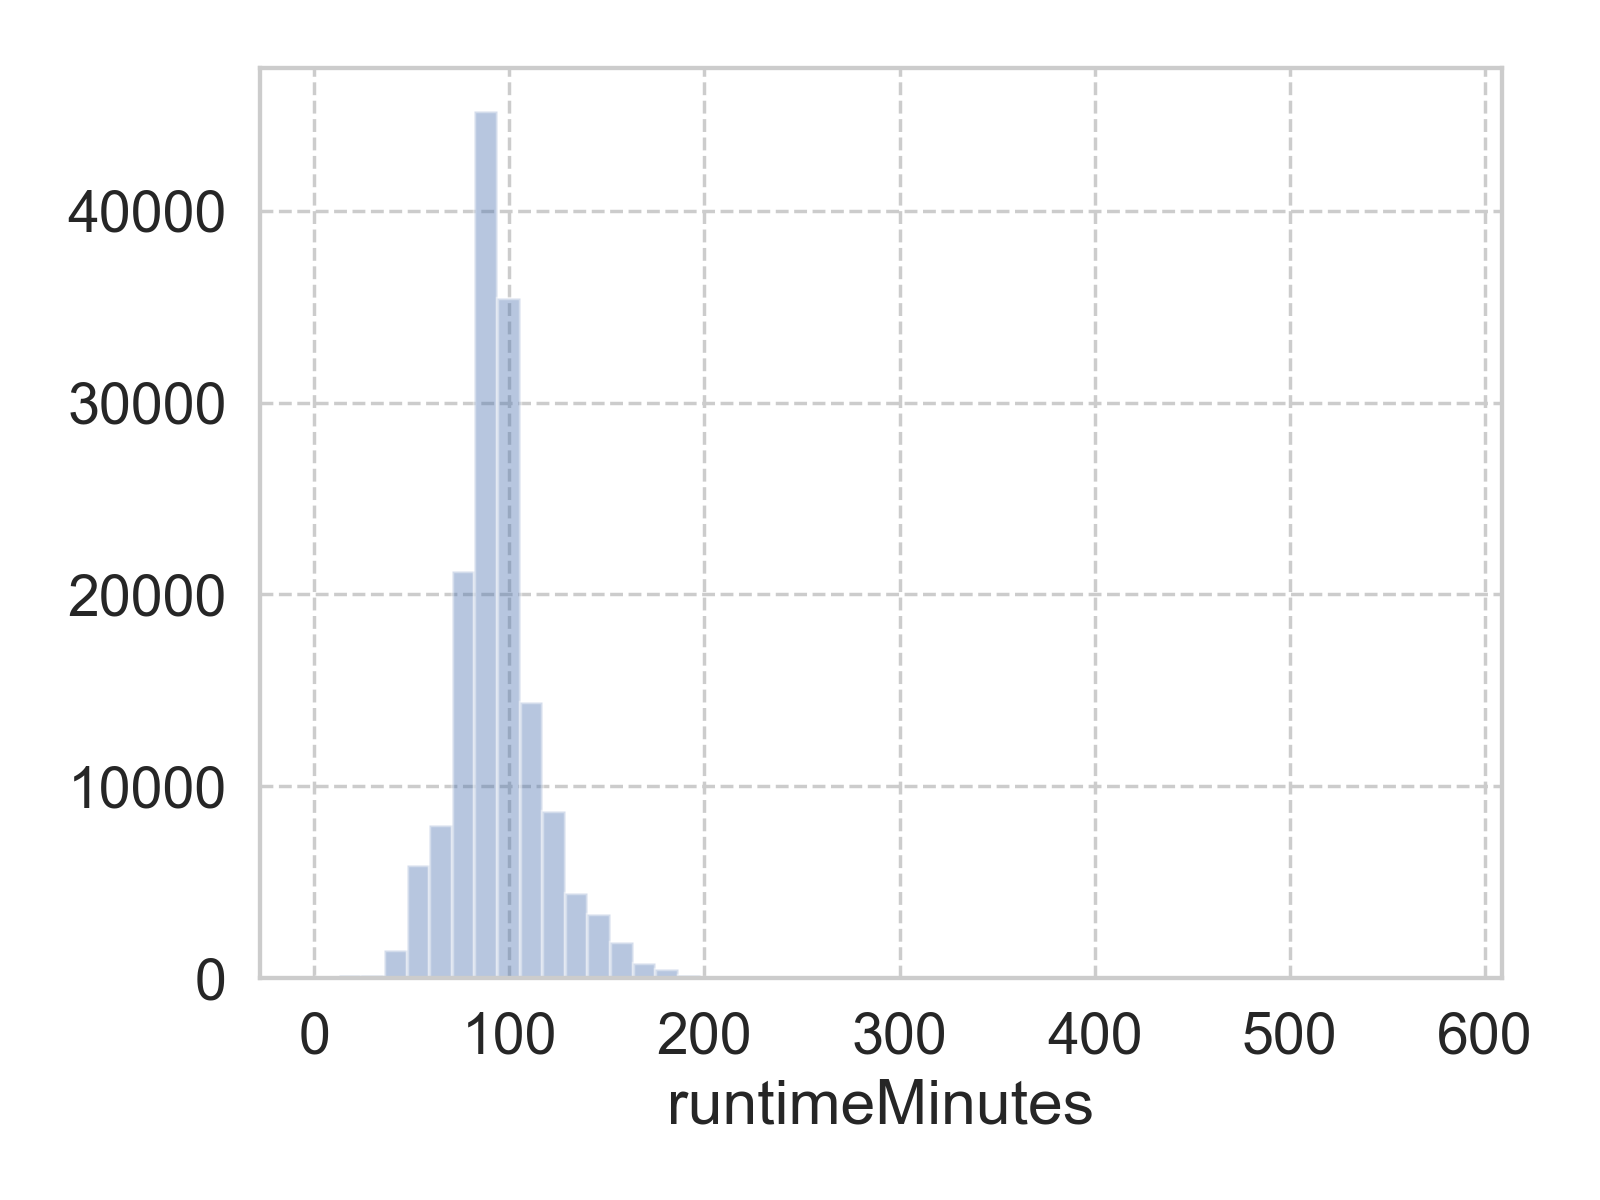

In [9]:
plt.close('all')
sns.distplot(movie['runtimeMinutes'], kde=False)
plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


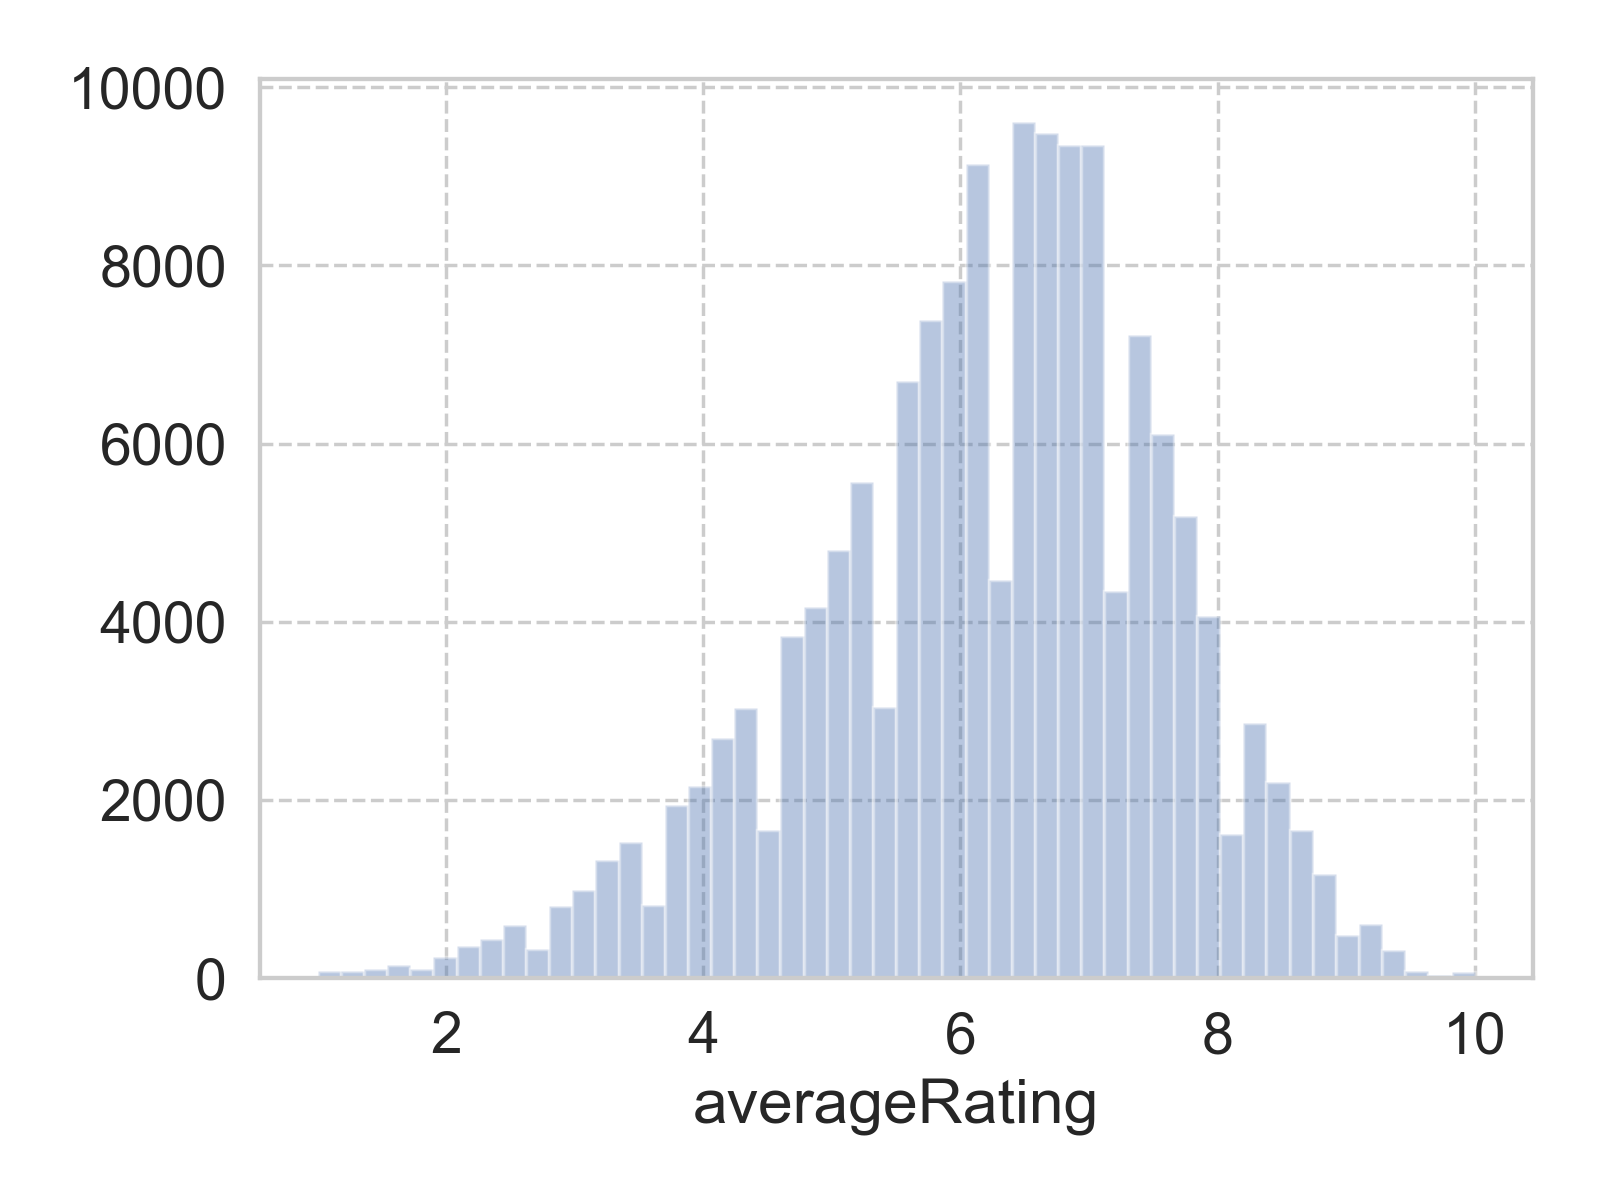

In [10]:
plt.close('all')
sns.distplot(movie['averageRating'], kde=False)
plt.tight_layout()
plt.show()

Sample size, for the equilvant test, calculated by the R power analyis package `powerTOSTtwo`, with `alpha = 0.05`, `power = 0.9`, and upper/lower bound d of 0.05, is 8658.
~~~R
powerTOSTtwo(alpha=0.05, 
             statistical_power=0.90, 
             low_eqbound_d=-0.05, 
             high_eqbound_d=0.05)
~~~

### Hypothesis test

Below we will start working on answering the question. First we will prepare two arrays, one with ratings from all movies with run time shorter or equal to 120 minutes, and the other for all movies with run time longer than 120 minutes. 

In [13]:
short = movie[movie['runtimeMinutes'] <= 120]['averageRating']
long = movie[movie['runtimeMinutes'] > 120]['averageRating']
print("Numbers of samples are {0:,} and {1:,}.".format(len(short), len(long)))

Numbers of samples are 136,443 and 15,760.


It turns out that we have enough sample size with the significance level, power, and effect size outlined above. Next we will move on to calculate test statistics.

In [38]:
import numpy as np
import scipy.stats as ss

mean_s, mean_l = np.mean(short), np.mean(long)
std_s, std_l = np.std(short), np.std(long)
tstat, pval = ss.ttest_ind(a=short, b=long, equal_var=False)
print("p value of NHST is: {}.".format(pval))

p value of NHST is: 3.8841392722554025e-133.


Since the p value is less than the preset significance lavel (0.05), we conclude that, the average rating between short and long movies are **statistically different**.

Finally, we will test the equivalence.

In [48]:
# pooled standard deviation
n_s, n_l= len(short), len(long)
std_p = np.sqrt(((n_s - 1) * std_s**2 + (n_l - 1) * std_l**2) 
                / (n_s + n_l - 2))

bound = 0.05 * np.sqrt(0.5 * std_s**2 + 0.5 * std_l**2)
t_lower = (mean_s - mean_l - bound) / (std_p * np.sqrt(1 / n_s + 1 / n_l))
t_upper = (mean_s - mean_l + bound) / (std_p * np.sqrt(1 / n_s + 1 / n_l))
# degree of freedom
df = ((std_s**2 / n_s + std_l**2 / n_l)**2 
      / ((std_s**2 / n_s)**2 / (n_s - 1) + (std_l**2 / n_l)**2 / (n_l - 1)))

print("The p value for lower bound of the equivalence test is: {}"
      .format(ss.t.cdf(x=t_lower, df=df)))
print("The p value for upper bound of the equivalence test is: {}"
      .format(1 - ss.t.cdf(x=t_upper, df=df)))

The p value for lower bound of the equivalence test is: 5.7191445666295e-184
The p value for upper bound of the equivalence test is: 1.0


### Conclusion

Based on the results above, we can conclude that, for the hypothesis: 

>The average imdb ratings for movies longer than 120 minutes and shorter than 120 minutes are equivalent.

We can reject it, with the signiciance level of 0.05, power of 0.9, and Cohen's d of 0.05. 

If we use the R's `TOSTtwo` package, as shown below, we will get the same conclusion.

~~~r
TOSTtwo(m1=6.16, m2=6.44, 
        sd1=1.40, sd2=1.31, 
        n1=136443, n2=15760, 
        low_eqbound_d=-0.05, high_eqbound_d=0.05)

TOST results:
t-value lower bound: -19.11 	p-value lower bound: 1.000
t-value upper bound: -31.33 	p-value upper bound: 1e-210
degrees of freedom : 20150.69

Equivalence bounds (Cohens d):
low eqbound: -0.05 
high eqbound: 0.05

Equivalence bounds (raw scores):
low eqbound: -0.0678 
high eqbound: 0.0678

TOST confidence interval:
lower bound 90% CI: -0.298
upper bound 90% CI:  -0.262

NHST confidence interval:
lower bound 95% CI: -0.302
upper bound 95% CI:  -0.258

Equivalence Test Result:
The equivalence test was non-significant, t(20150.69) = -19.115, p = 1.000, given equivalence bounds of -0.0678 and 0.0678 (on a raw scale) and an alpha of 0.05.

Null Hypothesis Test Result:
The null hypothesis test was significant, t(20150.69) = -25.221, p = 3.3e-138, given an alpha of 0.05.

Based on the equivalence test and the null-hypothesis test combined, we can conclude that the observed effect is statistically different from zero and statistically not equivalent to zero.
~~~

![title](Rplot.png)